# Calculate NDVI

The Normalized Difference Vegetation Index (NDVI) is a standard band-ratio calculation frequently used to analyze ecological remote sensing data. NDVI indicates whether the remotely-sensed target contains live green vegetation. When sunlight strikes objects, certain wavelengths of this spectrum are absorbed and other wavelengths are reflected. The pigment chlorophyll in plant leaves strongly absorbs visible light (with wavelengths in the range of 400-700 nm) for use in photosynthesis. The cell structure of the leaves, however, strongly reflects near-infrared light (wavelengths ranging from 700 - 1100 nm). Plants reflect up to 60% more light in the near infrared portion of the spectrum than they do in the green portion of the spectrum. By comparing the ratio of Near Infrared (NIR) to Visible (VIS) bands in hyperspectral data, we can obtain a quick look at vegetation in the region of interest. NDVI is a normalized measure of the difference between reflectance at near infrared and visible bands of the electromagnetic spectrum. 

The formula for NDVI is: $$NDVI = \frac{(NIR - VIS)}{(NIR+ VIS)}$$

<p>
<img src="files/ndvi_tree.png" style="width: 250px;"/>
<center><font size="2">Figure: (Wu et al. 2014)</font></center>
<center><font size="2">https://www.researchgate.net/figure/266947355_fig1_Figure-1-Green-vegetation-left-absorbs-visible-light-and-reflects-near-infrared-light</font></center>
</p>

Start by setting plot preferences and loading the neon_aop_refl_hdf5_functions module:

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

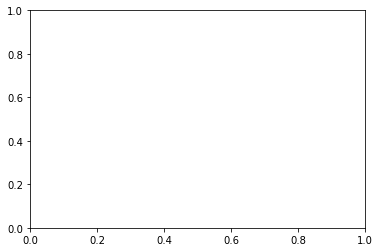

In [2]:
%load neon_aop_refl_hdf5_functions.py

## Read in SERC Flightline & Subset

In [3]:
#Define inputs
filename = '../data/SERC/hyperspectral/NEON_D02_SERC_DP1_20160807_160559_reflectance.h5'
sercRefl, sercRefl_md, wavelengths = h5refl2array(filename)

clipExtDict = {}
clipExtDict['xMin'] = 367400.
clipExtDict['xMax'] = 368100.
clipExtDict['yMin'] = 4305750.
clipExtDict['yMax'] = 4306350.

clipExtent = (clipExtDict['xMin'],clipExtDict['xMax'],clipExtDict['yMin'],clipExtDict['yMax'])
clipIndex = calc_clip_index(clipExtDict,sercRefl_md['ext_dict'])
sercReflSubset = subset_clean_refl(sercRefl,sercRefl_md,clipIndex)

## Stack NIR and VIS bands

Now that we have uploaded all the required functions, we can calculate NDVI and plot it. 
We will compute NDVI using bands 58 and 90. These correspond to wavelength ranges of:
$$band 58: \lambda_{VIS} = 666.6-671.6 nm$$ $$band 90: \lambda_{NIR} = 826.8-831.9 nm$$.

In [4]:
#Select bands to be used in the NDVI calculation
ndvi_bands = (58,90) #NIR and VIS (Red) bands

#Check the center wavelengths that these bands represent
band_width = wavelengths.value[1]-wavelengths.value[0]

print('band 58 wavelength range: ' + str(round(wavelengths.value[57]-band_width/2,2)) 
      + '-' + str(round(wavelengths.value[57]+band_width/2,2)) + ' nm')
print('band 90 wavelength range: ' + str(round(wavelengths.value[89]-band_width/2,2)) 
      + '-' + str(round(wavelengths.value[89]+band_width/2,2)) + ' nm')

#Use the stack_subset_bands function to create a stack of the subsetted red and NIR bands needed to calculate NDVI

ndvi_stack = stack_subset_bands(sercRefl,sercRefl_md,ndvi_bands,clipIndex)

band 58 wavelength range: 666.59-671.6 nm
band 90 wavelength range: 826.84-831.85 nm


# Calculate NDVI & Plot

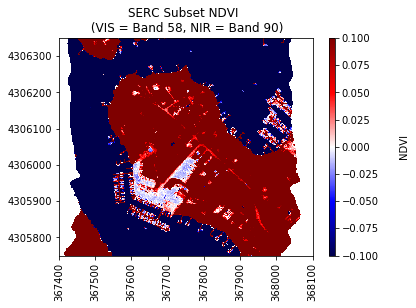

In [5]:
vis = ndvi_stack[:,:,0].astype(float)
nir = ndvi_stack[:,:,1].astype(float)

ndvi = np.divide((nir-vis),(nir+vis))

plot_band_array(ndvi,clipExtent,(0,np.max(ndvi)),\
                title='SERC Subset NDVI \n (VIS = Band 58, NIR = Band 90)',cmap_title='NDVI',colormap='seismic')

# Extract Spectra Using Masks

In the second part of this tutorial, we will learn how to extract the average spectra of pixels whose NDVI exceeds a specified threshold value. There are several ways to do this using `numpy`, including the mask functions `numpy.ma`, as well as `numpy.where` and finally using `boolean` indexing. 

To start, lets copy the NDVI calculated above and use booleans to create an array only containing NDVI > 0.6.

Mean NDVI > 0.6: 0.87


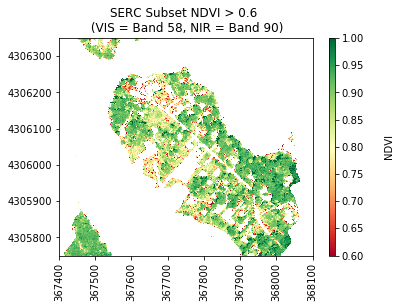

In [6]:
import copy
ndvi_gtpt6 = copy.copy(ndvi)
ndvi_gtpt6[ndvi<0.6] = np.nan  #set all pixels with NDVI < 0.6 to nan, keeping only values > 0.6
print('Mean NDVI > 0.6:',round(np.nanmean(ndvi_gtpt6),2))

plot_band_array(ndvi_gtpt6,clipExtent,(0.6,1),title='SERC Subset NDVI > 0.6 \n (VIS = Band 58, NIR = Band 90)',
                cmap_title='NDVI',colormap='RdYlGn')

# Function to calculate the mean spectra for reflectance values thresholed by NDVI using `numpy.ma`:

In [7]:
import numpy.ma as ma
def calculate_mean_masked_spectra(reflArray,ndvi,ndvi_threshold,ineq='>'):
    
    mean_masked_refl = np.zeros(reflArray.shape[2])
    
    for i in np.arange(reflArray.shape[2]):
        refl_band = reflArray[:,:,i]
        
        if ineq == '>':
            ndvi_mask = ma.masked_where((ndvi<=ndvi_threshold) | (np.isnan(ndvi)),ndvi)
        
        elif ineq == '<':
            ndvi_mask = ma.masked_where((ndvi>=ndvi_threshold) | (np.isnan(ndvi)),ndvi)
                
        else:
            print('ERROR: Invalid inequality. Enter < or >')
            
        masked_refl = ma.MaskedArray(refl_band,mask=ndvi_mask.mask)
        mean_masked_refl[i] = ma.mean(masked_refl)
            
    return mean_masked_refl

We can test out this function for various NDVI thresholds. We'll test two together, and you can try out different values on your own. Let's look at the average spectra for healthy vegetation (NDVI > 0.6), and for a lower threshold (NDVI < 0.3).

In [8]:
sercSpectra_ndvi_gtpt6 = calculate_mean_masked_spectra(sercReflSubset,ndvi,0.6)
sercSpectra_ndvi_ltpt3 = calculate_mean_masked_spectra(sercReflSubset,ndvi,0.3,ineq='<') 

In [9]:
import pandas

#Remove water vapor band windows & last 10 bands 
w = copy.copy(wavelengths.value)
w[((w >= 1340) & (w <= 1445)) | ((w >= 1790) & (w <= 1955))]=np.nan
w[-10:]=np.nan;  # the last 10 bands sometimes have noise - best to eliminate

nan_ind = np.argwhere(np.isnan(w))

sercSpectra_ndvi_gtpt6[nan_ind] = np.nan
sercSpectra_ndvi_ltpt3[nan_ind] = np.nan

#Create dataframe with masked NDVI mean spectra
sercSpectra_ndvi_df = pandas.DataFrame()
sercSpectra_ndvi_df['wavelength'] = w
sercSpectra_ndvi_df['mean_refl_ndvi_gtpt6'] = sercSpectra_ndvi_gtpt6
sercSpectra_ndvi_df['mean_refl_ndvi_ltpt3'] = sercSpectra_ndvi_ltpt3

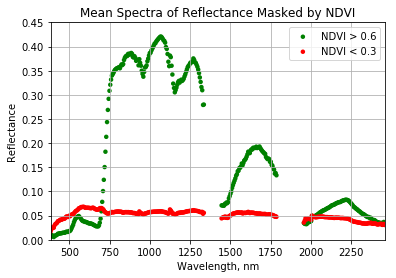

In [10]:
ax = plt.gca();
sercSpectra_ndvi_df.plot(ax=ax,x='wavelength',y='mean_refl_ndvi_gtpt6',color='green',
                         edgecolor='none',kind='scatter',label='NDVI > 0.6',legend=True);
sercSpectra_ndvi_df.plot(ax=ax,x='wavelength',y='mean_refl_ndvi_ltpt3',color='red',
                         edgecolor='none',kind='scatter',label='NDVI < 0.3',legend=True);
ax.set_title('Mean Spectra of Reflectance Masked by NDVI')
ax.set_xlim([np.nanmin(w),np.nanmax(w)]); ax.set_ylim(0,0.45)
ax.set_xlabel("Wavelength, nm"); ax.set_ylabel("Reflectance")
ax.grid('on'); 

## References

Wu C-D, McNeely E, Cedeño-Laurent JG, Pan W-C, Adamkiewicz G, Dominici F, et al. (2014) Linking Student Performance in Massachusetts Elementary Schools with the “Greenness” of School Surroundings Using Remote Sensing. PLoS ONE 9(10): e108548. doi:10.1371/journal.pone.0108548